# 🌱 Introduction - Let's Crack Fertilizer Prediction 🚀

"""
Hey there! 👋

Welcome to my notebook for the June 2025 Kaggle Playground competition — and this time we’re predicting the **best fertilizers** for different types of crops under various soil and weather conditions. Sounds cool, right? 😄

🧠 The main idea is simple: 
Based on features like temperature, rainfall, humidity, soil type, and crop type, we want to tell farmers which fertilizers will work best. And not just one — Kaggle wants us to predict **top 3** fertilizer names that fit the situation. So yeah, it’s a multi-label ranking problem 🔢.


### 📌 What you’ll find in this notebook:
I'm going to walk you through my entire approach step by step:
1. First, we’ll load and clean the data 🧹  
2. Then we’ll do a quick EDA to get a feel for things 📊  
3. After that, some preprocessing and maybe a little PCA for fun  
4. Finally, we’ll train XGBoost / LightGBM models and prepare a nice clean submission 💥

Stay tuned, let’s grow this solution like a crop 🌾 (pun intended 😄)!
"""


In [1]:
# 🌟 Let's get started — sabse pehle required libraries ko import karte hain!
import os
import numpy as np
import pandas as pd
import gc
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display            # for head()

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler  # scaler optional (future)
from sklearn.decomposition import PCA                              # optional (future)
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
import lightgbm as lgb

warnings.simplefilter(action='ignore')

# ============================================
# 📦 1) House-keeping & common settings
# ============================================
SEED   = 42
TARGET = "Fertilizer Name"          
np.random.seed(SEED)


In [2]:
# ============================================
#  2) Load data
# ===========================================

PLAYGROUND_DIR = "/kaggle/input/playground-series-s5e6"   #  Playground Series Season 5 Episode 6
FERTILIZER_DIR = "/kaggle/input/fertilizer-prediction"    #  Fertilizer Prediction dataset

#  Training set
df_train = pd.read_csv(f"{PLAYGROUND_DIR}/train.csv")

#  Test set (isko model pe chala kar submission banayenge)
df_test  = pd.read_csv(f"{PLAYGROUND_DIR}/test.csv")

# Original fertilizer-prediction data (feature engineering ke ideas yahan se nikal sakte hain)
df_fert  = pd.read_csv(f"{FERTILIZER_DIR}/Fertilizer Prediction.csv")

#  Submission template (yehi format Kaggle ko chahiye hota hai)
df_sub   = pd.read_csv(f"{PLAYGROUND_DIR}/sample_submission.csv")


🔍 Doing a little EDA before jumping into modeling...
📝 Train Data Sample:


,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


📐 Shape of train: (750000, 10)
📐 Shape of test: (250000, 9)
📐 Shape of external/original data: (100000, 9)

❓ Checking missing values:
id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

🧪 Unique Fertilizer Labels:
Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64


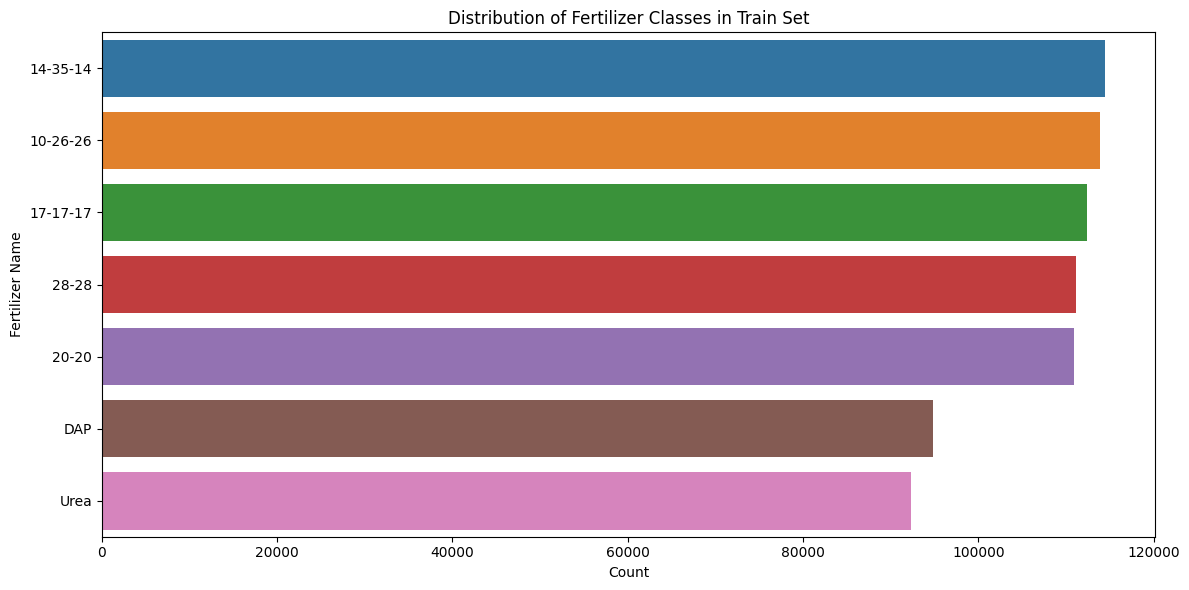

In [3]:
# ============================================
# 👀 Quick EDA — Data se dosti karte hain pehle 🤝
# ============================================

print("🔍 Doing a little EDA before jumping into modeling...")

# 1️⃣ Let's see how our training data looks
print("📝 Train Data Sample:")
display(df_train.head())

print("📐 Shape of train:", df_train.shape)
print("📐 Shape of test:", df_test.shape)
print("📐 Shape of external/original data:", df_fert.shape)

# 2️⃣ Check if any columns have missing values
print("\n❓ Checking missing values:")
print(df_train.isnull().sum())

# 3️⃣ Unique fertilizer labels — ye hi to predict krna hai 🎯
print("\n🧪 Unique Fertilizer Labels:")
print(df_train['Fertilizer Name'].value_counts())

# 4️⃣ Plot — Target distribution (thoda imbalance ho to pata chale)
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train, y='Fertilizer Name', order=df_train['Fertilizer Name'].value_counts().index)
plt.title("Distribution of Fertilizer Classes in Train Set")
plt.xlabel("Count")
plt.ylabel("Fertilizer Name")
plt.tight_layout()
plt.show()


In [4]:
# ============================================
# 🔧 4) Feature Engineering
# ============================================
# 🧪 Original fertilizer data ka backup – augment karne ke liye
df_fert_aug = df_fert.copy()

# 🔁 Data augmentation – original data ko 6x duplicate karke bada set bana rahe hain
for _ in range(6):
    df_fert = pd.concat([df_fert, df_fert_aug], axis=0)

# 🔍 Sirf numerical features nikal rahe hain (except 'id')
num_cols = [
    col for col in df_train.select_dtypes(include=['int64', 'float64']).columns 
    if col != 'id'
]

# Har dataframe pe transformation apply – binning, renaming, type optimization
for df in [df_train, df_test, df_fert]:
    
    #  Numerical columns ko binned categories mein convert kar rahe hain
    for col in num_cols:
        df[f'{col}_Binned'] = df[col].astype(str).astype('category')

    #  Typo fix: 'Temparature' → 'Temperature'
    df.rename(columns={'Temparature': 'Temperature'}, inplace=True)
    
    #  Memory optimization – int64 → int8, float64 → float16
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int8')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float16')



In [5]:
# ============================================
# 🔢 5) Data Preprocessing
# ============================================
# 🏷️  Categorical columns nikal rahe hain (target ko exclude kar ke)
cat_features = [
    col for col in df_train.select_dtypes(include=['object', 'category']).columns
    if col != "Fertilizer Name"
]

# 🔁 Label Encoding – saare categorical features ke liye
for col in cat_features:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    df_fert[col] = le.transform(df_fert[col])
    df_test[col]  = le.transform(df_test[col])

# 🎯 Target column "Fertilizer Name" ka bhi encoding
target_le = LabelEncoder()
df_train["Fertilizer Name"] = target_le.fit_transform(df_train["Fertilizer Name"])
df_fert["Fertilizer Name"]  = target_le.transform(df_fert["Fertilizer Name"])

# 🧽 Category conversion – memory optimize aur model ko help mile
for col in cat_features:
    df_train[col] = df_train[col].astype("category")
    df_fert[col]  = df_fert[col].astype("category")
    df_test[col]  = df_test[col].astype("category")

# 🎯 Feature-target split
X_train = df_train.drop(columns=["id", "Fertilizer Name"])
y_train = df_train["Fertilizer Name"]

# 📦 Test set (submission ke liye)
X_test = df_test.drop(columns=["id"])

# 🌱 Original fertilizer data split (SSL ya augmentation ke kaam aa sakta hai)
X_fert = df_fert.drop(columns=["Fertilizer Name"])
y_fert = df_fert["Fertilizer Name"]


In [6]:
# ============================================
# 6) Modelling
# ============================================
# 🎯 MAP@K metric – model ki top-K prediction ki accuracy ko evaluate karta hai
def mapk(actual, predicted, k=3):
    def apk(a, p, k):
        p = p[:k]
        score = 0.0
        hits = 0
        seen = set()
        for i, pred in enumerate(p):
            if pred in a and pred not in seen:
                hits += 1
                score += hits / (i + 1.0)
                seen.add(pred)
        return score / min(len(a), k)
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# ⚙️  Model configs – XGBoost, LightGBM (with & without GOSS)
model_configs = {
    'xgb': {
        'model': XGBClassifier,
        'params': {
            'objective': 'multi:softprob',
            'num_class': len(np.unique(y_train)),
            'max_depth': 8,
            'learning_rate': 0.03,
            'subsample': 0.8,
            'max_bin': 128,
            'colsample_bytree': 0.3,
            'colsample_bylevel': 1,
            'colsample_bynode': 1,
            'tree_method': 'hist',
            'random_state': 42,
            'eval_metric': 'mlogloss',
            'device': 'cuda',
            'enable_categorical': True,
            'n_estimators': 10000,
            'early_stopping_rounds': 50
        }
    },
    'lgb_goss': {
        'model': LGBMClassifier,
        'params': {
            'objective': 'multiclass',
            'num_class': len(np.unique(y_train)),
            'boosting_type': 'goss',
            'device': 'gpu',
            'colsample_bytree': 0.3275,
            'learning_rate': 0.02670,
            'max_depth': 9,
            'min_child_samples': 84,
            'n_estimators': 10000,
            'n_jobs': -1,
            'num_leaves': 229,
            'random_state': 42,
            'reg_alpha': 6.87997,
            'reg_lambda': 4.7391,
            'subsample': 0.5411,
            'categorical_feature': cat_features,
            'verbose': -1
        }
    },
    'lgb': {
        'model': LGBMClassifier,
        'params': {
            'objective': 'multiclass',
            'num_class': len(np.unique(y_train)),
            'device': 'gpu',
            'colsample_bytree': 0.4366,
            'learning_rate': 0.02617,
            'max_depth': 11,
            'min_child_samples': 67,
            'n_estimators': 10000,
            'n_jobs': -1,
            'num_leaves': 243,
            'random_state': 42,
            'reg_alpha': 6.38283,
            'reg_lambda': 9.39295,
            'subsample': 0.79898,
            'categorical_feature': cat_features,
            'verbose': -1
        }
    }
}



In [7]:
# ============================================
#  7) cross validation
# ============================================
# Cross-validation config (7 folds)
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

#  Storage for predictions and scores
oof_preds = {name: np.zeros((len(X_train), y_train.nunique())) for name in model_configs}
test_preds = {name: np.zeros((len(X_test), y_train.nunique())) for name in model_configs}
map3_scores = {name: [] for name in model_configs}

#  Training loop – har model + har fold
for name, config in model_configs.items():
    print(f"\n Training model: {name.upper()}")

    model = config['model'](**config['params'])

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
        x_tr, x_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        #  Augmenting training set with original fertilizer data
        x_tr = pd.concat([x_tr, X_fert], axis=0, ignore_index=True)
        y_tr = pd.concat([y_tr, y_fert], axis=0, ignore_index=True)

        #  Model training
        if name == 'xgb':
            model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_val, y_val)], verbose=0)
        else:
            model.fit(
                x_tr, y_tr,
                eval_set=[(x_val, y_val)],
                eval_metric='multi_logloss',
                callbacks=[lgb.early_stopping(stopping_rounds=100)]
            )

        # OOF + Test prediction
        oof_preds[name][valid_idx] = model.predict_proba(x_val)
        test_preds[name] += model.predict_proba(X_test) / skf.n_splits

        # 📊 Fold-wise MAP@3 score
        top_3 = np.argsort(oof_preds[name][valid_idx], axis=1)[:, -3:][:, ::-1]
        score = mapk([[label] for label in y_val], top_3)
        map3_scores[name].append(score)
        print(f"📈 Fold {fold+1} MAP@3: {score:.5f}")

    #  Final score for model
    avg_score = np.mean(map3_scores[name])
    print(f"{name.upper()} Average MAP@3: {avg_score:.5f}")


 Training model: XGB
📈 Fold 1 MAP@3: 0.37589
📈 Fold 2 MAP@3: 0.37752
📈 Fold 3 MAP@3: 0.37663
📈 Fold 4 MAP@3: 0.37760
📈 Fold 5 MAP@3: 0.37680
📈 Fold 6 MAP@3: 0.37432
📈 Fold 7 MAP@3: 0.37853
XGB Average MAP@3: 0.37675

 Training model: LGB_GOSS


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[816]	valid_0's multi_logloss: 1.88768
📈 Fold 1 MAP@3: 0.36961
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[769]	valid_0's multi_logloss: 1.8873
📈 Fold 2 MAP@3: 0.36923
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[823]	valid_0's multi_logloss: 1.88666
📈 Fold 3 MAP@3: 0.36936
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[825]	valid_0's multi_logloss: 1.88672
📈 Fold 4 MAP@3: 0.37061
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[805]	valid_0's multi_logloss: 1.88769
📈 Fold 5 MAP@3: 0.36888
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[784]	valid_0's multi_logloss: 1.89012
📈 Fold 6 MAP@3: 0.36729
Training until validation scores don't im

In [8]:
#===============================
# 8) stacking ensemble 
#==================================

# OOF aur Test Predictions ko concat karke meta-features banaye stacking ke liye
stack_train = np.hstack([oof_preds[name] for name in oof_preds])     # Train meta features
stack_test  = np.hstack([test_preds[name] for name in test_preds])  # Test meta features

# Meta-model (LGBM as final blender)
meta_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_train)),
    learning_rate=0.03,
    n_estimators=10000,
    random_state=42,
    verbose=-1
)

print("Training stacking ensemble...")

#  Final prediction containers
final_oof  = np.zeros((len(y_train), y_train.nunique()))
final_test = np.zeros((len(X_test), y_train.nunique()))
ensemble_scores = []

# Stacking cross-validation loop
for fold, (train_idx, valid_idx) in enumerate(skf.split(stack_train, y_train)):
    x_tr, x_val = stack_train[train_idx], stack_train[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    #  Meta model training
    meta_model.fit(
        x_tr, y_tr,
        eval_set=[(x_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=100)]
    )

    # Meta predictions
    final_oof[valid_idx] = meta_model.predict_proba(x_val)
    final_test += meta_model.predict_proba(stack_test) / skf.n_splits

    # MAP@3 evaluation
    top_3 = np.argsort(final_oof[valid_idx], axis=1)[:, -3:][:, ::-1]
    score = mapk([[lab] for lab in y_val], top_3)
    ensemble_scores.append(score)

    print(f" Ensemble Fold {fold+1}: MAP@3 = {score:.5f}")

# 🏁 Final average score
avg_ensemble_score = np.mean(ensemble_scores)
print(f"\n Ensemble Average MAP@3: {avg_ensemble_score:.5f}")


Training stacking ensemble...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	valid_0's multi_logloss: 1.8764
 Ensemble Fold 1: MAP@3 = 0.37804
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[134]	valid_0's multi_logloss: 1.87581
 Ensemble Fold 2: MAP@3 = 0.37956
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's multi_logloss: 1.87479
 Ensemble Fold 3: MAP@3 = 0.37862
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's multi_logloss: 1.87478
 Ensemble Fold 4: MAP@3 = 0.37911
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's multi_logloss: 1.87671
 Ensemble Fold 5: MAP@3 = 0.37864
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[146]	valid_0's multi_lo

In [9]:
#==================================
# 9) Saving and submissions
#=================================
# Results save karne ke liye directory bana rahe hain
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

#  Stacking ensemble predictions save (Offline analysis ke liye useful)
np.save(f"{output_dir}/stacking_oof.npy", final_oof)
np.save(f"{output_dir}/stacking_test.npy", final_test)

#  Har base model ke OOF aur test predictions bhi separately save kar rahe hain
for name in oof_preds:
    np.save(f"{output_dir}/{name}_oof.npy", oof_preds[name])
    np.save(f"{output_dir}/{name}_test.npy", test_preds[name])

# Final test predictions ko label form mein convert karna (Top-3)
top_3 = np.argsort(final_test, axis=1)[:, -3:][:, ::-1]
labels = target_le.inverse_transform(top_3.ravel()).reshape(top_3.shape)

# Kaggle submission file ready kar rahe hain
submission_df = pd.DataFrame({
    'id': df_sub['id'],
    'Fertilizer Name': [' '.join(row) for row in labels]
})
submission_df.to_csv("submission.csv", index=False)

# Score report save kar rahe hain (sab model aur ensemble ke MAP@3 scores)
with open(f"{output_dir}/scores.txt", "w") as f:
    for name, scores in map3_scores.items():
        f.write(f"{name} MAP@3 Scores: {scores}\n")
        f.write(f"{name} Average MAP@3: {np.mean(scores):.5f}\n")
    f.write(f"Ensemble MAP@3 Scores: {ensemble_scores}\n")
    f.write(f"Ensemble Average MAP@3: {np.mean(ensemble_scores):.5f}\n")


# ✅ Conclusion — And That’s a Wrap! 🚀

"""
Thanks for sticking around till the end! 🙌

In this notebook, we went from raw CSVs to a full-blown stacked ensemble pipeline 🧱
Here’s a quick recap of what we did:

So what’s next? 🤔
- Try tuning hyperparameters (learning rate, depth, leaves etc.)
- Experiment with more features from external datasets
- Test CatBoost as a 3rd base model in the stack
- Try transformer-based tabular models like TabNet or SAINT 🔥
- Explore label correlations (some fertilizers often occur together)

💬 Let me know if you fork this and try something cool — I’d love to see what you build!

Until next time — may your models be accurate and your kernels reproducible 😄  
"""

-----------

# 💬 Let's Connect — I’d Love to Hear from You! 🌍✨

"""
Thanks for checking out my notebook! 😊

If you found this helpful, learned something new, or even if you have a better idea (I’m always open to learning!) — let’s chat!  
I’d really appreciate your feedback, suggestions, or just a friendly hello 👋

📬 You can reach me here:
- 📌 Kaggle: https://www.kaggle.com/sheemamasood
- 💼 LinkedIn: https://www.linkedin.com/in/sheema-masood/
- 📧 Email: sheemamasood381@gmail.com

Also, feel free to fork this notebook and tag me if you do something cool with it! 🔥  
Let’s grow and build awesome things together. 🚀

#AI #MachineLearning #Kaggle #FertilizerPrediction #Stacking #XGBoost #LightGBM #OpenToCollab
"""
